In [1]:
import pandas as pd

In [2]:
events_data = pd.read_csv('event_data_train.csv')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [3]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['day'] = events_data.date.dt.date

In [4]:
submission_data = pd.read_csv('submissions_data_train.csv')
submission_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [5]:
submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit = 's')
submission_data['day'] = submission_data.date.dt.date

In [6]:
users_data = events_data.groupby('user_id', as_index= False)\
        .agg({'timestamp': 'max'})\
        .rename({'timestamp':'last_timestamp'}, axis = 'columns')
now = 1526772811
drop_out_threasold = 2592000

users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threasold

In [7]:
users_scores = submission_data.pivot_table(index='user_id',\
                        columns = 'submission_status',\
                        values = 'step_id',\
                        aggfunc = 'count',\
                        fill_value = 0)\
                        .reset_index()
users_data = users_data.merge(users_scores, on = 'user_id', how = 'outer')
users_data = users_data.fillna(0)

In [8]:
users_invent_data = events_data.pivot_table(index = 'user_id',
                        columns = 'action',
                        values  = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0).reset_index()
users_data = users_data.merge(users_invent_data, how = 'outer')
users_days = events_data.groupby('user_id').day.nunique()
users_days.to_frame().reset_index()
users_data = users_data.merge(users_days, on = 'user_id', how = 'outer')
users_data['passed_corse'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


<Axes: >

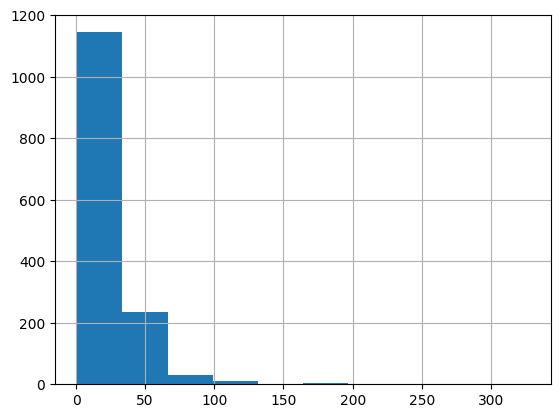

In [9]:
users_data[users_data.passed_corse].day.hist()

In [10]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [11]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [12]:
users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [13]:
%%time
# первый способ фильтрации пользователей (очень плохой)
# events_data_list = []
# for user_id in users_data.user_id:
#     min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
#     time_threshold = min_user_time + 3 * 24 * 60 * 60
#     user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_threshold)]
#     events_data_list.append(user_events_data)
# event_data_train = pd.concat(events_data_list)
# event_data_train.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [14]:
%%time
# второй способ фильтрации пользователей
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)
learning_time_threshold = 3 * 24 * 60 * 60
user_min_time['user_learning_time_threshold'] = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]
events_data_train.head()

CPU times: user 2.56 s, sys: 558 ms, total: 3.12 s
Wall time: 3.14 s


,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [15]:
# проверка количества уникальных дней
events_data_train.groupby('user_id').day.nunique().max()

4

In [16]:
submission_data['user_time'] = submission_data.user_id.map(str) + '_' + submission_data.timestamp.map(str)
submission_data = submission_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submission_data_train = submission_data[submission_data.user_time <= submission_data.user_learning_time_threshold]
submission_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434605177


In [17]:
# проверка количества уникальных дней
submission_data_train.groupby('user_id').day.nunique().max()

4

In [18]:
X = submission_data_train \
    .groupby('user_id') \
    .day.nunique() \
    .to_frame() \
    .reset_index() \
    .rename(columns={'day': 'days'})

In [19]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [20]:
steps_tried = submission_data_train \
    .groupby('user_id')\
    .step_id.nunique()\
    .to_frame()\
    .reset_index()\
    .rename(columns={'step_id': 'steps_tried'})

In [21]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [22]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [23]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [24]:
submission_data_pivot = submission_data_train.pivot_table(index='user_id',
                                                         columns='submission_status',
                                                         values='step_id',
                                                         aggfunc='count',
                                                         fill_value=0).reset_index()

In [25]:
submission_data_pivot.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27


In [26]:
X = X.merge(submission_data_pivot)
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [27]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [28]:
events_data_pivot = events_data_train.pivot_table(index='user_id',
                                                columns='action',
                                                values='step_id',
                                                aggfunc='count',
                                                fill_value=0).reset_index()[['user_id', 'viewed']]

In [29]:
events_data_pivot.head()

action,user_id,viewed
0,1,1
1,2,9
2,3,20
3,5,1
4,7,1


In [30]:
X = X.merge(events_data_pivot, how='outer')

In [31]:
X = X.fillna(0)

In [32]:
X = X.merge(users_data[['user_id', 'passed_corse', 'is_gone_user']], how='outer')

In [33]:
X = X[X.is_gone_user | X.passed_corse]

In [34]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_corse,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [35]:
X.groupby(['passed_corse', 'is_gone_user']).user_id.count()

passed_corse  is_gone_user
False         True            16560
True          False             141
              True             1284
Name: user_id, dtype: int64

In [36]:
y = X.passed_corse.map(int)

In [37]:
X = X.drop(['passed_corse', 'is_gone_user'], axis=1)

In [38]:
X = X.set_index(X.user_id)

In [39]:
X = X.drop('user_id', axis=1)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


### Задача о непроходимом стэпе

In [40]:
submissions_df = pd.read_csv('submissions_data_train.csv')
submissions_df.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [41]:
# не учитывается фактор того, что шаг должен быть последнием (по timestamp)
check_status_df = submissions_df[submissions_df.submission_status == 'wrong'] \
    .groupby('step_id', as_index=False)\
    .agg({'user_id': 'count'})\
    .sort_values('user_id', ascending=False)
check_status_df.head()

,step_id,user_id
4,31978,16084
11,32031,13373
19,32202,13002
44,33481,10300
12,32075,10003
